# Training in mini-batches: Stochastic gradient descent

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parrt/fundamentals-of-deep-learning/blob/main/notebooks/8.SGD-minibatch-mnist.ipynb)

By [Terence Parr](https://explained.ai).

We've been using generic gradient descent to optimize our model so far.  Because we've been estimating gradients using the entire $\bf X$ matrix, we call this batch gradient descent. Each update of the model parameters occurs after considering all training instances (after each epoch). For batch gradient descent, there is one loss function computation per epoch.  If we process the training data in chunks rather than a single batch, we call it mini-batch gradient descent, or more commonly stochastic gradient descent (SGD). It is called stochastic because of the randomness and, hence, imprecision introduced by the computation of gradients on a subset of the training data. After we've computed a gradient and updated weights for all mini-batches, we've finished an epoch. Next, we shuffle the batches, and iterate until convergence our we run out of AWS credits.

As before, we should run the network on a GPU.  The easiest way is just to click the icon there to run it at colab, and turn on the GPU runtime. (Go to "Change runtime type" under the runtime menu then select "GPU" under hardware accelerator; then select "Run all" under the runtime menu.) Or, you can still run it on your laptop/CPU; it'll just be slower.

## Why minibatch vs batch gradient descent?

<a href="https://twitter.com/ylecun/status/989610208497360896"><img src="https://explained.ai/rnn/images/lecunn-batch-size.png" width="250" align="right"></a>
Sometimes we have so much data that it will not fit on our GPU all at once; decent GPUs typically have around 12G of RAM.  For big problems, we need to break it up into batches.
 
Also, and possibly a more important goal, is to get better generalization; i.e., smaller validation loss.  There are a lot of semi-recent papers and discussions that support the conclusion that we want batch size to be as small as possible, due to the stochastic nature of training, because the model parameter search bounces around down into lower and better minima.

* [Tradeoff batch size vs. number of iterations to train a neural network](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network)
* [Why mini batch size is better than one single “batch” with all training data?](https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data)
* [Revisiting Small Batch Training for Deep Neural Networks](https://arxiv.org/abs/1804.07612)

On the other hand, we want the batch size to be as large as possible for efficiency on GPUs. The smaller the batch size, the smaller the matrices upon which we perform arithmetic and, hence, the lower the benefit of parallelism. Even if we know for sure that a lower batch size on a particular problem leads to better generality, for practical efficiency reasons, we might need to increase the batch size so that the training terminates in our lifetime.

Let's redo the MNIST example using the GPU but with SGD.

## Support code

In [1]:
import os
import sys
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

# Figure out whether we have a GPU; if not use the CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [2]:
def plot_loss(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def plot_accur(history, ax=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Epochs")
    accur = history[:,2]
    val_accur = history[:,3]
    ax.set_ylim(0,1.05)
    ax.plot(accur, label='accur')
    ax.plot(val_accur, label='val_accur')
    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    ax.legend(loc='lower right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/{os.environ['USER']}/Desktop/{file}.pdf")
        
def imgrid(images, digits, dim=(5,5), figsize=(4, 4)):
    fig, axes = plt.subplots(*dim, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        img_as_row = images[i]
        img28x28 = img_as_row.reshape(28,28)
        ax.axis('off') # don't show x, y axes
        ax.imshow(img28x28, cmap='Greys')
        ax.text(0, 8, digits[i], color='#313695', fontsize=15)

## Load data

As before, let's load a sample of 10,000 MNIST images:

In [3]:
df_mnist = pd.read_csv("https://mlbook.explained.ai/data/mnist-10k-sample.csv.zip")
X = df_mnist.drop('digit', axis=1).values # get just pixels
y = df_mnist['digit'].values              # get just digit value

In [4]:
X.shape

(10000, 784)

In [5]:
# shuffle
n = len(X)
idx = np.random.randint(0,n,n)
X = X[idx,:]
y = y[idx]

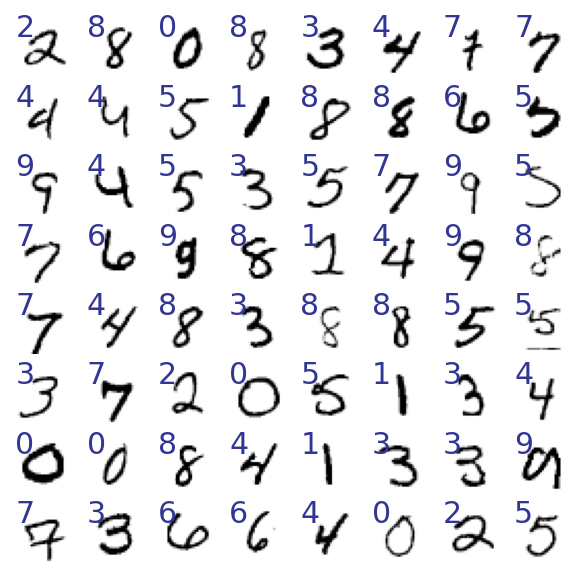

In [6]:
imgrid(X,digits=y,dim=(8,8),figsize=(5,5))

As before, create tensors from the $\bf X$ and $\bf y$ data, move the data to the GPU, and split out a validation set:

In [7]:
X = torch.tensor(X).float().to(device)
y = torch.tensor(y).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Training loop

Now let's create a training function that uses stochastic gradient descent, which means updating the model parameters by computing the loss for a subset (a minibatch) of the overall training data. Previously we computed the predictions and loss with:

```python
y_pred = model(X_train)
loss = F.cross_entropy(y_pred, y)
```

But, now we need to break up `X_train` into chunks and iterate across the chunks. So that simple prediction and loss computation becomes another loop:

<img src="images/minibatch-train.png" width="800">

We also must shuffle the data set at the start of every epoch to avoid getting the training loop into a rut.  To get the best stochastic nature, thus improving generality, we should not use the same sequence of mini-batches.

In [8]:
def sgdtrain(model, X_train, y_train, X_test, y_test, 
             learning_rate = .0001, nepochs=2000, batch_size=32):
    n = len(X_train)
    nbatches = n // batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = []
    best_loss = 1e10
    best_model = None
    best_epoch = -1
    for epoch in range(nepochs+1):
        epoch_training_loss = 0.0
        # Must shuffle before each epoch
        shuffle_idx = torch.randperm(len(X_train))
        X_train_shuffled = X_train[shuffle_idx]
        y_train_shuffled = y_train[shuffle_idx]
        for p in range(0, n, batch_size):  # do one epoch
            # extract a batch at index p
            batch_X = X_train_shuffled[p:p+batch_size]
            batch_y = y_train_shuffled[p:p+batch_size]
            y_pred = model(batch_X)
            # Assume model yields softmax probabilities
            loss = F.cross_entropy(y_pred, batch_y)
            epoch_training_loss += loss.detach().item()

            optimizer.zero_grad()
            loss.backward() # autograd computes w1.grad, b1.grad, ...
            optimizer.step()

        epoch_training_loss /= nbatches # average batch loss

        # Computing metrics in a no_grad() block is for memory efficiency and speed;
        # means to avoid doing any of the auto gradient computations
        with torch.no_grad():
            y_pred = model(X_train)
            y_pred = torch.argmax(y_pred, axis=1)
            ncorrect = torch.sum(y_pred==y_train)
            accur = ncorrect.float() / len(y_train)

            y_test_pred = model(X_test)
            loss_test = F.cross_entropy(y_test_pred, y_test)
            y_test_pred = torch.argmax(y_test_pred, axis=1)
            ncorrect = torch.sum(y_test_pred==y_test)
            loss_accur = ncorrect.float() / len(y_test)
        
        # Save all of the computations; loss.item() detaches
        # the hidden auto gradient computation graph.
        # Gets just the value. Otherwise, this procedure
        # runs out of memory on the GPU. 
        history.append((loss.item(), loss_test, accur, loss_accur))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} cross entropy loss {loss:7.4f}   test loss {loss_test:7.4f}")

    print(f"BEST test cross entropy loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

## Train with batch gradient descent

Let's get started by defining the same model we've been using:

In [9]:
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

To verify that our stochastic gradient descent training algorithm is correct, let's perform batch gradient descent by setting the mini-batch size to the length of the training set. 

In [19]:
%%time
# On a CPU, this takes about 40 seconds but only 4 seconds on a GPU at colab.
# It only took 20 seconds to do the batch version of this in the previous notebook
# because we are doing more work in this version of the training loop.
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .03, nepochs=1000,
                     batch_size=len(X_train) # perform batch not mini-batch gradient descent
                  )

Epoch    0 cross entropy loss  1.4914   test loss  1.8749
Epoch  100 cross entropy loss  1.5864   test loss  1.5968
Epoch  200 cross entropy loss  1.4835   test loss  1.5047
Epoch  300 cross entropy loss  1.4769   test loss  1.5013
Epoch  400 cross entropy loss  1.4761   test loss  1.5000
Epoch  500 cross entropy loss  1.4751   test loss  1.4998
Epoch  600 cross entropy loss  1.4749   test loss  1.4995
Epoch  700 cross entropy loss  1.4749   test loss  1.4993
Epoch  800 cross entropy loss  1.4747   test loss  1.4982
Epoch  900 cross entropy loss  1.4746   test loss  1.4982
Epoch 1000 cross entropy loss  1.4746   test loss  1.4982
BEST test cross entropy loss 1.498 at epoch 816
CPU times: user 2min 9s, sys: 6.53 s, total: 2min 15s
Wall time: 35 s


In [20]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.986


In [21]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.964


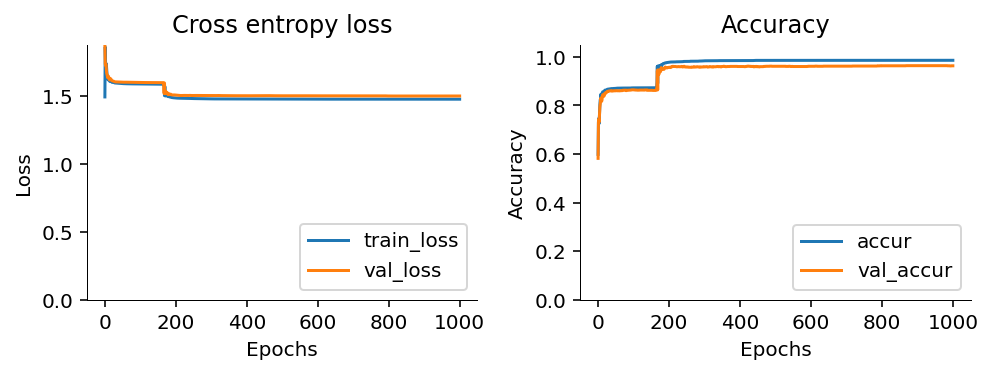

In [22]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0])
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

## Try mini-batch

Ok the batch results look like what we saw before so let's assume our algorithm works correctly. Now, let's try a stochastic run using mini-batches.  One of the first things to notice is that, given the stochastic nature due to the imprecise gradient estimates, we need to decrease the learning rate. Otherwise, we'll jump too far away along a path different from the true gradient. Let's create the same model except use a batch size of 8 images rather than `len(X_train)` to compute gradients via the loss function.  Also, we don't need to train very long because we know that a decent model appears almost immediately.

In [14]:
%%time
# make sure to create a new model otherwise it starts from where it left off
model = nn.Sequential(
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50, 10),  # 10 output classes (0-9)
    nn.Softmax(dim=1)
)

model = model.to(device) # make sure the model runs on the GPU as well

# Mini-batching dramatically slows down the process compared to batch gradient descent
# because the GPU can only operate on small chunks of data at once, rather than one
# big matrix during batch gradient descent.
# This takes about 51s on my CPU.  Oddly enough, it takes longer on the colab
# GPU, 1min 10s, likely because we are not getting that much parallelism and my CPU
# is faster for sequential operations.
history,_ = sgdtrain(model, X_train, y_train, X_test, y_test,
                     learning_rate = .001, # small learning rate due to imprecise gradients
                     nepochs=50,           # very few iterations for speed
                     batch_size=8          # very small batch size
                  )

Epoch    0 cross entropy loss  1.6826   test loss  1.5681
Epoch    5 cross entropy loss  1.5000   test loss  1.5158
Epoch   10 cross entropy loss  1.4612   test loss  1.5102
Epoch   15 cross entropy loss  1.4612   test loss  1.5038
Epoch   20 cross entropy loss  1.4612   test loss  1.5047
Epoch   25 cross entropy loss  1.4612   test loss  1.5039
Epoch   30 cross entropy loss  1.4612   test loss  1.4985
Epoch   35 cross entropy loss  1.4612   test loss  1.5024
Epoch   40 cross entropy loss  1.6176   test loss  1.5010
Epoch   45 cross entropy loss  1.4615   test loss  1.4977
Epoch   50 cross entropy loss  1.5804   test loss  1.4957
BEST test cross entropy loss 1.495 at epoch 49
CPU times: user 2min 41s, sys: 5.42 s, total: 2min 47s
Wall time: 43.8 s


In [15]:
y_pred = model(X_train)
y_pred = torch.argmax(y_pred, axis=1)
ncorrect = torch.sum(y_pred==y_train)
train_accur = ncorrect.float() / len(y_train)
print(f"Training accuracy {train_accur:.3f}")

Training accuracy 0.988


In [16]:
y_test_pred = model(X_test)
y_test_pred = torch.argmax(y_test_pred, axis=1)
ncorrect = torch.sum(y_test_pred==y_test)
test_accur = ncorrect.float() / len(y_test)
print(f"Validation accuracy {test_accur:.3f}")

Validation accuracy 0.965


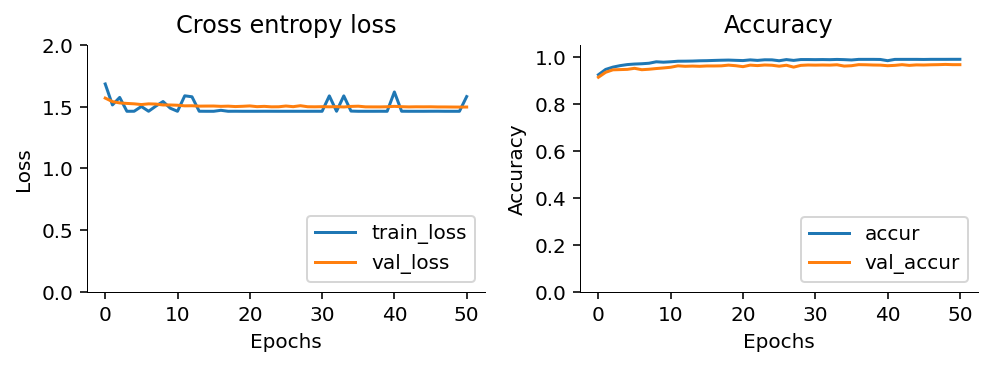

In [17]:
fig, axes = plt.subplots(1,2, figsize=(7,2.5))
plot_loss(history, ax=axes[0], maxy=2)
plot_accur(history, ax=axes[1])
axes[0].set_title("Cross entropy loss")
axes[1].set_title("Accuracy")
plt.show()

In the end mini-batch gradient descent does not dramatically change our generality here. But, remember, we are very close to 100% accurate already, so we must fight very hard for improvements at this point. (Mini-batch is also wildly less efficient.)   To truly get a better classifier, we need to use  convolutional neural networks.

#### Exercise

Compare and explain the difference in the training loss history plots for mini-batch and batch gradient descent.

<details>
<summary>Solution</summary>
    The loss history for mini-batch gradient descent is going to be much noisier because our estimates of the gradient are imprecise. That means we will sometimes bounce in the wrong direction when trying to reach the minimum loss location. The validation loss is smooth because we are computing it on the entire data set, not batches.  We are only mini-batching the training data.
</details>

## Try a variety of mini batch sizes

Epoch    0 cross entropy loss  1.5167   test loss  1.5686
Epoch    5 cross entropy loss  1.5040   test loss  1.5215
Epoch   10 cross entropy loss  1.4662   test loss  1.5076
Epoch   15 cross entropy loss  1.4612   test loss  1.5123
Epoch   20 cross entropy loss  1.4612   test loss  1.5019
Epoch   25 cross entropy loss  1.4612   test loss  1.5018
Epoch   30 cross entropy loss  1.4612   test loss  1.5020
Epoch   35 cross entropy loss  1.4612   test loss  1.5016
Epoch   40 cross entropy loss  1.4612   test loss  1.5017
Epoch   45 cross entropy loss  1.4612   test loss  1.4975
Epoch   50 cross entropy loss  1.4612   test loss  1.4983
BEST test cross entropy loss 1.496 at epoch 47
Epoch    0 cross entropy loss  1.6647   test loss  1.6536
Epoch    5 cross entropy loss  1.5168   test loss  1.5403
Epoch   10 cross entropy loss  1.5781   test loss  1.5213
Epoch   15 cross entropy loss  1.4753   test loss  1.5137
Epoch   20 cross entropy loss  1.5266   test loss  1.5105
Epoch   25 cross entropy 

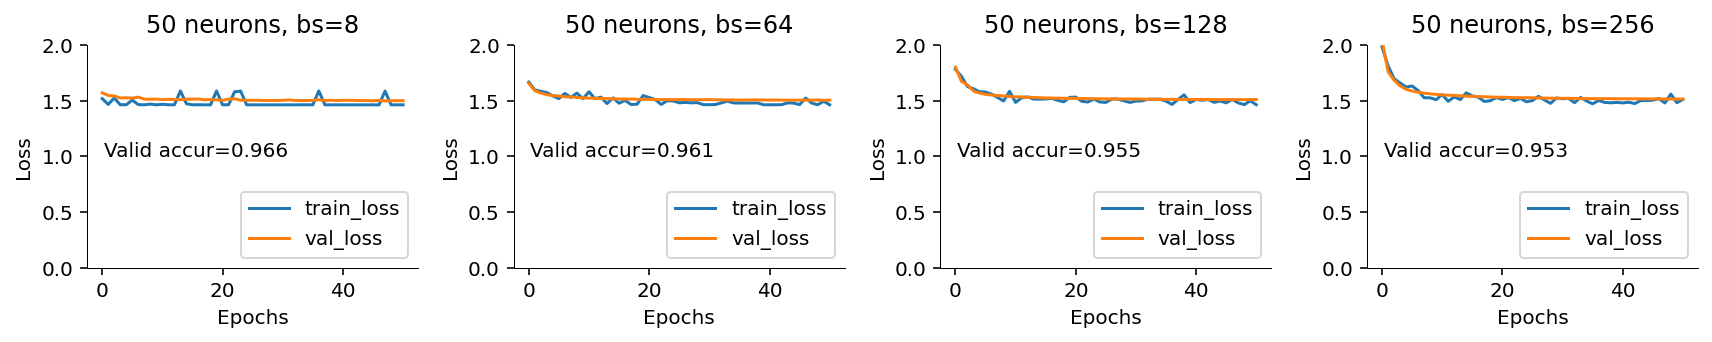

In [18]:
n_neurons = 50
fig, axes = plt.subplots(1, 4,figsize=(12,2.5))
ncols = X.shape[1]
for bs,ax in zip([8,64,128,256],axes):
    model = nn.Sequential(
        nn.Linear(784, n_neurons),
        nn.ReLU(),
        nn.Linear(n_neurons, 10),  # 10 output classes (0-9)
        nn.Softmax(dim=1)
    )
    model = model.to(device)
    history,best_model = sgdtrain(model, X_train, y_train, X_test, y_test,
                                 learning_rate = .001, nepochs=50, # few epochs for speed
                                 batch_size=bs
                                )
    y_test_pred = best_model(X_test)
    y_test_pred = torch.argmax(y_test_pred, axis=1)
    ncorrect = torch.sum(y_test_pred==y_test)
    test_accur = ncorrect.float() / len(y_test)
    ax.set_title(f"{n_neurons} neurons, bs={bs}")
    ax.text(.25, 1.0, f"Valid accur={test_accur:.3f}")
    plot_loss(history, ax=ax, maxy=2)

plt.tight_layout()
plt.show()

At least for this model, data set, and hyper parameters, increasing the batch size reduces generality.  The validation accuracy gradually decreases as we increase batch size.